In [2]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct
from scipy.stats import binom, poisson, norm


mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = True
pathFigures = '/home/thea/MesterTesen/WrittenWork/Figures/'


import sys

sys.path.append('../../')
sys.path.append('../')

from GetCoreData_fct import GetCoreData
from BackDiffuse_LT import BackDiffuse
from Interpolation_Class import Interpolation
from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength
from transforms import transforms
from Decon import SpectralDecon
from sigmaSolver import sigma_Solver
from SignalAttenuation import Attenuation, AnnualLayerThick


def func_gaussian(x, N, mu, sigma, a):
    
    return N * norm.pdf(x, mu, sigma) + a


from sigmaSolver import sigma_Solver

def TempEst_analytical_arr(diffLens_in = np.array([0.08]), Accum_in = 0.3, rhoMeans_in = np.array([804.3])):
    diffLens = diffLens_in
    sigmaSolver_inst = sigma_Solver()
    T_intEst = np.zeros(len(diffLens))

    for i in range(len(diffLens)):
        T_est = sigmaSolver_inst.solveTemp(sigma_data = diffLens[i], accum = Accum_in, rho_CO = rhoMeans_in[i])
        T_intEst[i] = T_est
    return T_intEst



In [17]:
site = 'SiteE'

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']


pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'
diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))


#dataConst = pd.read_csv(pathResults+site+'_diffLens_ConstraintsGauss.csv', ' ', header=None)
#t_w = dataConst.loc[0]
#diffLens = dataConst.loc[1]
#dTambs = dataConst.loc[2]
#dLakis = dataConst.loc[3]


sigMin = 0.0
sigMax = 0.15

diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
#dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
#dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]


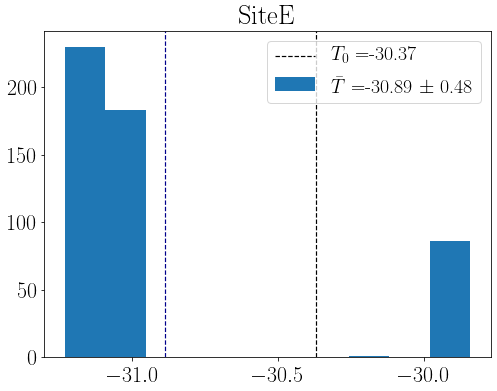

In [18]:
rhosUse = np.ones_like(diffLensUse)*804.3

Ts = TempEst_analytical_arr(diffLens_in=diffLensUse, Accum_in=accum0, rhoMeans_in = rhosUse)
T_mean = np.mean(Ts-273.15)
T_std = np.std(Ts-273.15)


fig, ax = plt.subplots(figsize=(8,6))
ax.hist(Ts-273.15, bins=10, label=r'$\bar{T}=$'+f'{T_mean:.2f} $\pm$ {T_std:.2f}')
ax.axvline(Temp0, ls='--',c='k',lw=1.2, label=f'$T_0=${Temp0}')
ax.axvline(T_mean, ls='--',c='darkblue',lw=1.2)
ax.set_title(site)
ax.legend(fontsize=20)

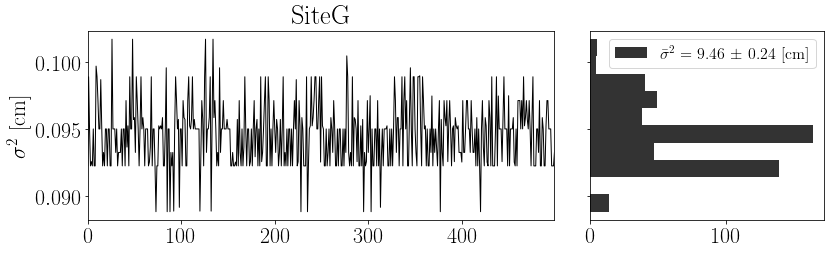

In [74]:
x = np.arange(0,len(diffLensUse))

sigmaMean = np.mean(diffLensUse)*100
sigmaSTD = np.std(diffLensUse)*100
sigmaMean_LT = np.mean(dLakis-dTambs)
sigmaSTD_LT = np.std(dLakis-dTambs)

fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,4), sharex='col', sharey='row')


ax[0].plot(x,diffLensUse,c='k',lw=1)#,marker='.',ls='None')
ax[0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
ax[0].set_title(site)
ax[1].hist(diffLensUse, bins=10, orientation="horizontal", color='k',alpha=0.8, label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
#ax[0,1].set(xlabel='Counts')
ax[1].legend(fontsize=16, loc='upper right')


fig.tight_layout()

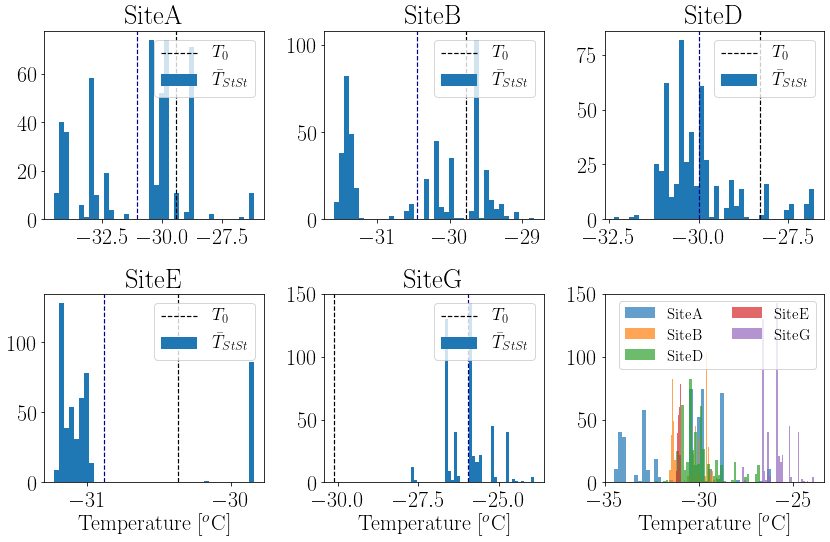

In [46]:
sites = ['SiteA', 'SiteB','SiteD', 'SiteE', 'SiteG']

fig, axs = plt.subplots(2,3, figsize=(12,8))
for site, ax in zip(sites, axs.flatten()):
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']


    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

    diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))
    sigMin = 0.0
    sigMax = 0.15

    diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
    #dTambsUse = dTambs[(diffLens>sigMin) & (diffLens < sigMax)]
    #dLakisUse = dLakis[(diffLens>sigMin) & (diffLens < sigMax)]



    rhosUse = np.ones_like(diffLensUse)*804.3

    Ts = TempEst_analytical_arr(diffLens_in=diffLensUse, Accum_in=accum0, rhoMeans_in = rhosUse)
    T_mean = np.mean(Ts-273.15)
    T_std = np.std(Ts-273.15)


    #fig, ax = plt.subplots(figsize=(8,6))
    ax.hist(Ts-273.15, bins=40, label=r'$\bar{T}_{StSt}$')#+f'{T_mean:.2f} $\pm$ {T_std:.2f}')
    ax.axvline(Temp0, ls='--',c='k',lw=1.2, label=f'$T_0$')
    ax.axvline(T_mean, ls='--',c='darkblue',lw=1.2)
    ax.set_title(site)
    ax.legend(fontsize=18, loc='upper right')
    
    axs.flatten()[-1].hist(Ts-273.15, bins=40, alpha=0.7, label=site)
axs.flatten()[-1].legend(fontsize=15, ncol=2)
axs.flatten()[-3].set_xlabel('Temperature [$^{o}$C]')
axs.flatten()[-2].set_xlabel('Temperature [$^{o}$C]')
axs.flatten()[-1].set_xlabel('Temperature [$^{o}$C]')
fig.tight_layout()

if saveFigs:
    fig.savefig('../../WrittenWork/Figures/' + 'AllCores_StStTempEsts.png')

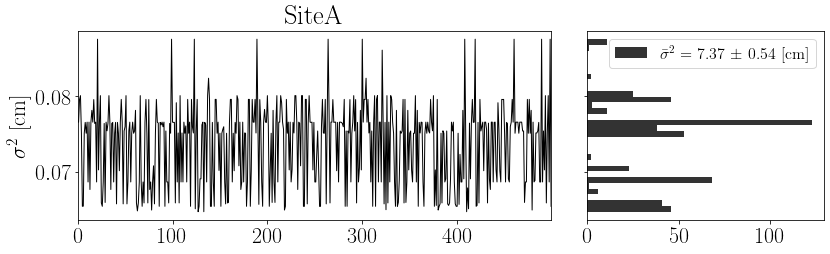

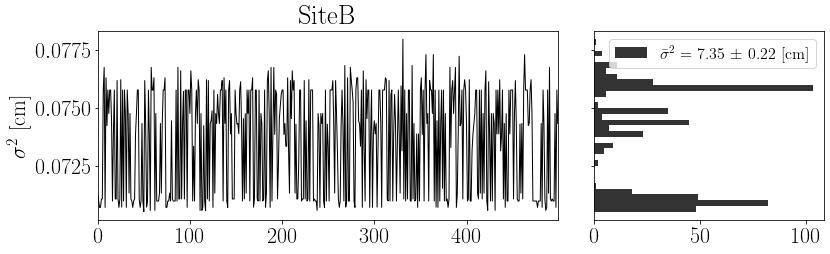

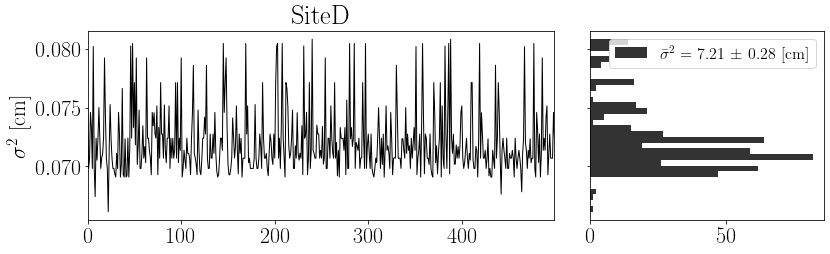

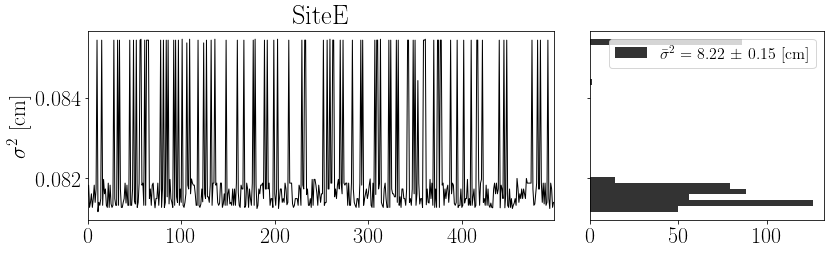

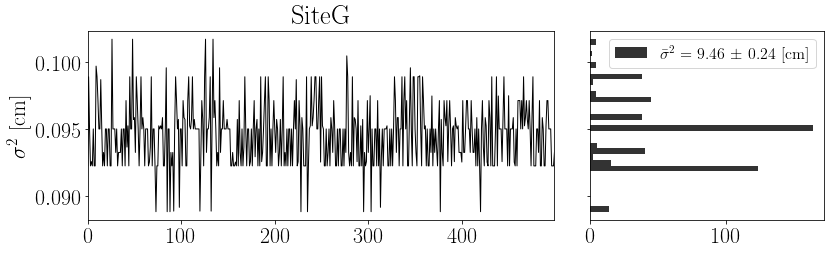

In [7]:

for site in sites:
    CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')
    coreNames = CoresSpecs['CoreName']


    core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
    CoreSpecs = CoresSpecs.iloc[core_idx]
    dTamb = CoreSpecs['dTamb']
    dLaki = CoreSpecs['dLaki']
    accum0 = CoreSpecs['Accum0']
    accumIE = CoreSpecs['Accum1']
    Temp0 = CoreSpecs['T0']


    pathResults = '/home/thea/MesterTesen/Analysis/ResultsGeneration/ResultsData/'

    diffLens, dTambs, dLakis = np.array(pd.read_csv(pathResults + site+'_diffLens_GaussDistwDepths_sigNmonths2_NDCT2.csv', ' ', header=None))
    sigMin = 0.0
    sigMax = 0.15

    diffLensUse = diffLens[(diffLens>sigMin) & (diffLens < sigMax)]
    
    x = np.arange(0,len(diffLensUse))

    sigmaMean = np.mean(diffLensUse)*100
    sigmaSTD = np.std(diffLensUse)*100
    sigmaMean_LT = np.mean(dLakis-dTambs)
    sigmaSTD_LT = np.std(dLakis-dTambs)

    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[2,1]},figsize=(12,4), sharex='col', sharey='row')


    ax[0].plot(x,diffLensUse,c='k',lw=1)#,marker='.',ls='None')
    ax[0].set(xlim=(min(x),max(x)), ylabel='$\sigma^2$ [cm]')
    ax[0].set_title(site)
    ax[1].hist(diffLensUse, bins=30, orientation="horizontal", color='k',alpha=0.8, label=r'$\bar\sigma^2 =$ ' + f'{sigmaMean:.2f} $\pm$ {sigmaSTD:.2f} [cm]');
    #ax[0,1].set(xlabel='Counts')
    ax[1].legend(fontsize=16, loc='upper right')


    fig.tight_layout()